In [1]:
#imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
%matplotlib inline
from skimage.feature import hog
import os
import glob
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC # "Support Vector Classifier"

In [2]:
# Define a function to return characteristics of the dataset 
def data_look(fp_list, notfp_list):
    data_dict = {}
    data_dict["n_fps"] = len(fp_list)
    data_dict["n_notfps"] = len(notfp_list)
    fp_img = mpimg.imread(fp_list[0])
    data_dict["image_shape"] = fp_img.shape
    data_dict["data_type"] = fp_img.dtype
    return data_dict

In [3]:
#function to print images
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

In [4]:
#Read fps i.e. fishplates and not-fps i.e. non-fishplate images

#Data folders
fishplate_dir =     'C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/'
non_fishplate_dir = 'C:/Users/hp/Desktop/Mod1-IITR/fishplate/neg/'

# images are divided up into fishplate and non-fishplate
fps = []
notfps = []

# Read fishplate images
images = glob.iglob(fishplate_dir + '*.jpg', recursive=True)
for image in images:
        fps.append(image)
        
# Read non-fishplate images
images = glob.iglob(non_fishplate_dir + '*.jpg', recursive=True)
for image in images:
        notfps.append(image)
    
data_info = data_look(fps, notfps)

print('Your function returned a count of', data_info["n_fps"], 'fps and', data_info["n_notfps"], 'nonfps')
print('Size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

Your function returned a count of 66 fps and 66 nonfps
Size:  (100, 100, 3)  and data type: uint8


Example fp images


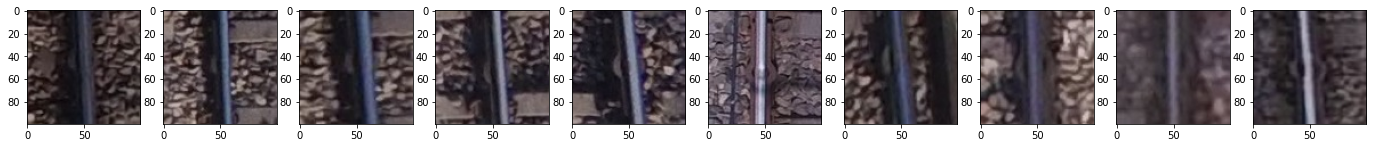

Example not-fp images


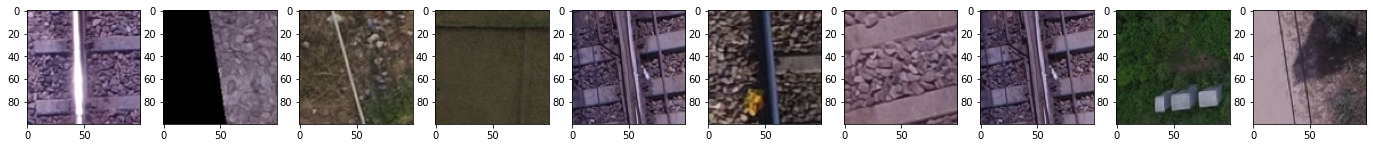

In [5]:
#Visualize some input images
import random

num_images = 10

# Just for fun choose random fp / not-fp indices and plot example images   
fps_samples = random.sample(list(fps), num_images)
notfp_samples = random.sample(list(notfps), num_images)
    
# Read in fp / not-fp images
fp_images = []
notfp_images = []
for sample in fps_samples:
    fp_images.append(mpimg.imread(sample))
    
for sample in notfp_samples:
    notfp_images.append(mpimg.imread(sample))

visualize_images(fp_images, num_images, "Example fp images")
visualize_images(notfp_images, num_images, "Example not-fp images")

Text(0.5, 1.0, 'YUV')

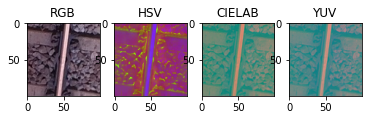

In [6]:
#Plot the examples of colour spaces on 1 image
img = cv2.imread('C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/40.jpg')
plt.subplot(141)
plt.imshow(img)
plt.title('RGB')
plt.subplot(142)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
plt.imshow(hsv) 
plt.title('HSV')
plt.subplot(143)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
plt.imshow(lab)
plt.title('CIELAB')
plt.subplot(144)
yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
plt.imshow(yuv) 
plt.title('YUV')

In [7]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

Text(0.5, 1.0, 'not fp HOG')

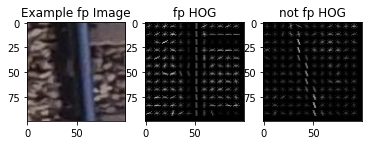

In [8]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

fp_features, hog_image = get_hog_features(cv2.cvtColor(fp_images[1], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

notfp_features, notfp_hog_image = get_hog_features(cv2.cvtColor(notfp_images[2], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(131)
plt.imshow(fp_images[2])
plt.title('Example fp Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('fp HOG')
plt.subplot(133)
plt.imshow(notfp_hog_image, cmap='gray')
plt.title('not fp HOG')

In [9]:
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [10]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [11]:
#the following code is for finding HOG using code #1  : features.py
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,transform_sqrt=True, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
            visualize=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
            visualize=False, feature_vector=feature_vec)
        return features

In [13]:
def search_windowfeature(image2,color_space='RGB',orient=16,pix_per_cell=16, cell_per_block=2):       
        test_img = cv2.cvtColor(window,cv2.COLOR_RGB2GRAY)    
        hogfeaturestest, hog_imagetest = get_hog_features(test_img, orient,pix_per_cell, cell_per_block,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresizetest=hogfeaturestest.size
        hogfeaturestest=np.reshape(hogfeaturestest,(featuresizetest,),order='C')
        hogfeaturestest= hogfeaturestest.reshape(1,-1)
        return hogfeaturestest    


In [15]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [16]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 500] # Min and max in y to search in slide_window()

In [ ]:
if __name__ == '__main__':
    posfeatures=[]
    h1=[]
    positive= 'C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/'
    for image_file in os.listdir(positive):
        image = mpimg.imread(os.path.join(positive,image_file))

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray=np.resize(gray,(100,100))
        
        hogfeatures, hog_image = get_hog_features(gray, orient=9,pix_per_cell=16, cell_per_block=2,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresize=hogfeatures.size
        hogfeatures=np.reshape(hogfeatures,(featuresize,),order='C')
        hogfeatures= hogfeatures.reshape(1,-1)
        posfeatures.append(hogfeatures)
        tpos=np.concatenate(posfeatures)  
        h1.append(np.concatenate(posfeatures))

    negfeatures=[]
    h2=[]
    negative= 'C:/Users/hp/Desktop/Mod1-IITR/fishplate/neg/'
    for image_file1 in os.listdir(negative):
        image1 = mpimg.imread(os.path.join(negative,image_file1))

        gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        gray1=np.resize(gray1,(100,100))
        
        hogfeatures1, hog_image1 = get_hog_features(gray1, orient=9,pix_per_cell=16, cell_per_block=2,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresize1=hogfeatures1.size
        hogfeatures1=np.reshape(hogfeatures1,(featuresize1,),order='C')
        hogfeatures1= hogfeatures1.reshape(1,-1)

        negfeatures.append(hogfeatures1)
        t=np.concatenate(negfeatures)  
        h2.append(np.concatenate(negfeatures))
    
#SVM classification 
svc = LinearSVC()
X_scaler = StandardScaler() 
X = np.vstack((tpos,t))
X_scaler.fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(tpos)), np.zeros(len(t))))
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)

# Check the training time for the SVC
time1=time.time()
svm_model_linear=svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-time1, 2), 'Seconds to train SVC...')
svm_predictions = svm_model_linear.predict(X_test)
svm_predictions = svc.predict(X_test)
print('Test Accuracy of SVC = ',round(svm_model_linear.score(X_test, y_test),4)) 


imdir = 'C:/Users/hp/Desktop/Mod1-IITR/test4/'
xcord=[]
ycord1=[]
(winW, winH) = (100,100)
for image_file in os.listdir(imdir):
    image2 = mpimg.imread(os.path.join(imdir, image_file))

    on_windows=[]
    pred=[]
    clone = image2.copy()

    for (x, y, window) in sliding_window(image2, stepSize=32, windowSize=(winW, winH)): 
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        windowstestfeat = search_windowfeature(window,color_space=color_space,orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block) 
        testfeaturesh = X_scaler.transform(windowstestfeat) 
        prediction =svm_model_linear.predict(testfeaturesh) 
        pred.append(prediction)
        if prediction==1:
            on_windows.append(window)
            xcord.append(x)
            ycord1.append(y) 
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window",clone)  
        k=cv2.waitKey(1)
        
    cv2.imwrite('356hog.png', clone)    # for saving the image after the prediction of the whole image

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.26 Seconds to train SVC...
Test Accuracy of SVC =  0.963
